# MODULE 2 : ADVANCED CLASSIFICATION

---

### libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

---

### 0) Data Visualization

dataset completo preprocessed -> Target variable: **groupedRating = [3, 4, 5, 6, 7, 8, 9]**

In [2]:
# =============================================================================
# PART 1.1: Data Loading, Preprocessing & Normalization (Normal Preprocessed Dataset)
# =============================================================================

# 1. Load the preprocessed train and test datasets from CSV
train_data_preprocessed = pd.read_csv("../../../0) dataset/1) preprocessed dataset/train_preprocessed.csv")
test_data_preprocessed  = pd.read_csv("../../../0) dataset/1) preprocessed dataset/test_preprocessed.csv")

# Drop the 'Unnamed: 0' column if it exists
train_data_preprocessed.drop(columns='Unnamed: 0', inplace=True, errors='ignore')
test_data_preprocessed.drop(columns='Unnamed: 0', inplace=True, errors='ignore')

# 2. Map the original "rating" into the new target "groupedRating"
def map_rating(r):
    # Map ratings 0, 1, 2, and 3 to 3; leave other ratings unchanged.
    if r in [0, 1, 2, 3]:
        return 3
    else:
        return r

train_data_preprocessed["groupedRating"] = train_data_preprocessed["rating"].apply(map_rating)
test_data_preprocessed["groupedRating"]  = test_data_preprocessed["rating"].apply(map_rating)

# Define the new target variable
target = "groupedRating"

# 3. Extract numerical columns dynamically from the training set
attributes = list(np.unique(train_data_preprocessed.select_dtypes(include=['int', 'float64']).columns))

# Remove dangerous features: remove the original "rating" and the target "groupedRating"
unwanted_values = {'rating', 'groupedRating', 'averageRating'}
attributes = [attr for attr in attributes if attr not in unwanted_values]
print("Initial numerical features:", attributes)

# 4. Define the feature matrix (X) and target vector (y) for both train and test sets
# Use new variable names to avoid conflict with outliers removed dataset
X_train_preprocessed = train_data_preprocessed[attributes].values
y_train_preprocessed = train_data_preprocessed[target].values

X_test_preprocessed  = test_data_preprocessed[attributes].values
y_test_preprocessed  = test_data_preprocessed[target].values

# 5. Normalize the features using StandardScaler
scaler_preprocessed = MinMaxScaler()
X_train_scaled_preprocessed = scaler_preprocessed.fit_transform(X_train_preprocessed)
X_test_scaled_preprocessed  = scaler_preprocessed.transform(X_test_preprocessed)

Initial numerical features: ['Action', 'Adventure', 'Animation', 'Asia', 'Australia/Oceania', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Europe', 'Middle East', 'North Africa', 'North America', 'Series', 'Short', 'South Africa', 'South America', 'awardNominationsExcludeWinsLog', 'awardWinsLog', 'castNumberLog', 'companiesNumberLog', 'criticReviewsTotalLog', 'directorsCreditsLog', 'externalLinksLog', 'isAdult', 'movie', 'numRegionsLog', 'numVotesLog', 'other', 'others', 'quotesTotalLog', 'runtimeMinutes', 'short', 'startYear', 'totalCreditsLog', 'totalImagesLog', 'totalVideosLog', 'userReviewsTotalLog', 'writerCreditsLog']


### 1) Logistic Regression

[logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Classification Report:
               precision    recall  f1-score   support

           3       0.33      0.00      0.01      1585
           4       0.35      0.01      0.02      2688
           5       0.32      0.19      0.23      6279
           6       0.33      0.36      0.35     11696
           7       0.45      0.54      0.49     14657
           8       0.21      0.35      0.26      6677
           9       0.09      0.00      0.00      1278

    accuracy                           0.35     44860
   macro avg       0.30      0.21      0.19     44860
weighted avg       0.35      0.35      0.32     44860



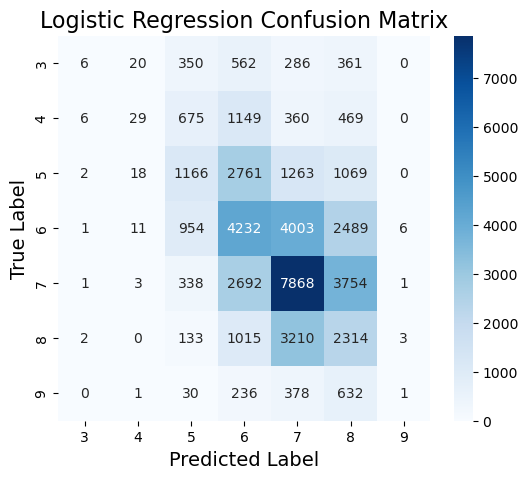

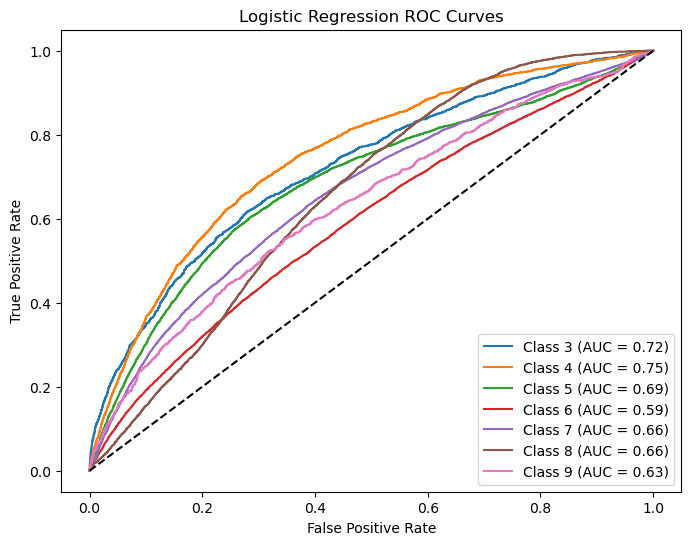

In [3]:
# =============================================================================
# PART 1: Logistic Regression for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Logistic Regression Fit and Predict ---
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_lr = lr_model.predict(X_test_scaled_preprocessed)

# --- Step 2: classification report
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_lr))

# --- Step 3: Compute the confusion matrix.
cm_lr = confusion_matrix(y_test_preprocessed, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Logistic Regression Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
# Binarize the true labels using the classes from the best logistic regression model
classes_lr = lr_model.classes_
y_test_lr_bin = label_binarize(y_test_preprocessed, classes=classes_lr)
y_score_lr = lr_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class.
fpr_lr, tpr_lr, roc_auc_lr = dict(), dict(), dict()
for i, cls in enumerate(classes_lr):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_lr_bin[:, i], y_score_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# Plot the ROC curves for all classes.
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_lr):
    plt.plot(fpr_lr[i], tpr_lr[i], label=f'Class {cls} (AUC = {roc_auc_lr[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Logistic Regression ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2) Support Vector Machines

### 2.1) Linear Support Vector Machines

[linear svm](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

- LinearSVC is similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. The main differences between LinearSVC and SVC lie in the loss function used by default, and in the handling of intercept regularization between those two implementations.

Classification Report:
               precision    recall  f1-score   support

           3       0.62      0.01      0.02      1585
           4       0.43      0.01      0.02      2688
           5       0.34      0.18      0.23      6279
           6       0.33      0.36      0.34     11696
           7       0.45      0.55      0.49     14657
           8       0.21      0.34      0.26      6677
           9       0.04      0.00      0.00      1278

    accuracy                           0.35     44860
   macro avg       0.35      0.21      0.19     44860
weighted avg       0.36      0.35      0.32     44860



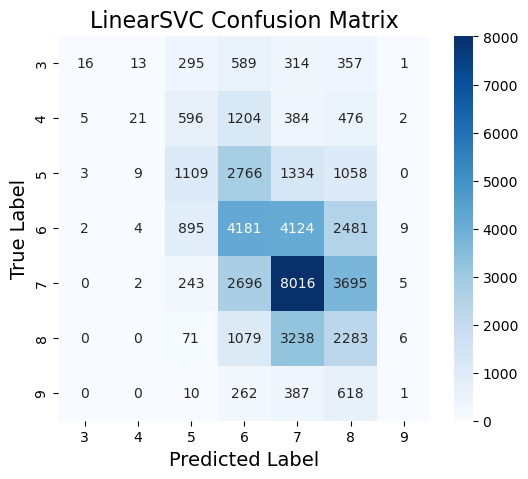

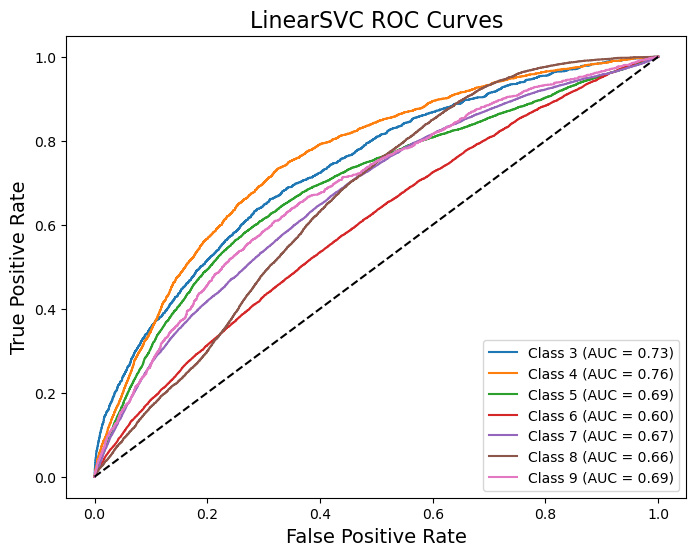

In [4]:
# =============================================================================
# PART 2: LinearSVC for Grouped Rating Prediction
# =============================================================================

# --- Step 1: LinearSVC Train and Test (wrap with CalibratedClassifierCV) ---
linear_svc = LinearSVC(random_state=42)
calibrated_linear_svc = CalibratedClassifierCV(linear_svc, cv=5)
calibrated_linear_svc.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_linear_svc = calibrated_linear_svc.predict(X_test_scaled_preprocessed)

# --- Step 2: classification report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_linear_svc))

# --- Step 3: Confusion Matrix
cm_linear_svc = confusion_matrix(y_test_preprocessed, y_pred_linear_svc)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=(6, 5))
sns.heatmap(cm_linear_svc, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('LinearSVC Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_linear_svc = calibrated_linear_svc.classes_
y_test_linear_svc_bin = label_binarize(y_test_preprocessed, classes=classes_linear_svc)
y_score_linear_svc = calibrated_linear_svc.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class.
fpr_linear_svc, tpr_linear_svc, roc_auc_linear_svc = dict(), dict(), dict()
for i, cls in enumerate(classes_linear_svc):
    fpr_linear_svc[i], tpr_linear_svc[i], _ = roc_curve(y_test_linear_svc_bin[:, i], y_score_linear_svc[:, i])
    roc_auc_linear_svc[i] = auc(fpr_linear_svc[i], tpr_linear_svc[i])

# Plot the ROC curves for all classes.
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_linear_svc):
    plt.plot(fpr_linear_svc[i], tpr_linear_svc[i], label=f'Class {cls} (AUC = {roc_auc_linear_svc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("LinearSVC ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 2.2) Support Vector Machine

[svm](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [5]:
# =============================================================================
# PART 3: SVC for Grouped Rating Prediction
# =============================================================================

"""
best_accuracy = 0.0
best_kernel = None
best_y_pred = None
best_svc_model = None

for kernel in ['rbf', 'poly']:
    print(f"==== Evaluating SVC with kernel: {kernel} ====")
    
    # --- Step 1: SVM Train and Test with Different Kernels ---
    svc_model = SVC(probability=True, random_state=42, kernel=kernel)
    svc_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
    y_pred_svc = svc_model.predict(X_test_scaled_preprocessed)
    
    # --- Step 2: Classification Report and Accuracy ---
    acc = accuracy_score(y_test_preprocessed, y_pred_svc)
    print(f"Accuracy for kernel '{kernel}': {acc:.4f}\n")
    print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_svc))
    
    # Update best model if current kernel yields higher accuracy.
    if acc > best_accuracy:
        best_accuracy = acc
        best_kernel = kernel
        best_y_pred = y_pred_svc
        best_svc_model = svc_model

print(f"\nBest kernel based on accuracy: '{best_kernel}' with accuracy {best_accuracy:.4f}")

# --- Step 3: Confusion Matrix for the Best Kernel ---
cm_svc = confusion_matrix(y_test_preprocessed, best_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svc, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title(f'SVC Confusion Matrix - Best Kernel: {best_kernel}', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification (Best Kernel) ---
# Binarize the true test labels.
classes_svc = best_svc_model.classes_
y_test_svc_bin = label_binarize(y_test_preprocessed, classes=classes_svc)
y_score_svc = best_svc_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class.
fpr_svc, tpr_svc, roc_auc_svc = dict(), dict(), dict()
for i, cls in enumerate(classes_svc):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_svc_bin[:, i], y_score_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

# Plot the ROC curves for all classes.
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_svc):
    plt.plot(fpr_svc[i], tpr_svc[i], label=f'Class {cls} (AUC = {roc_auc_svc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("SVC ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()
"""

'\nbest_accuracy = 0.0\nbest_kernel = None\nbest_y_pred = None\nbest_svc_model = None\n\nfor kernel in [\'rbf\', \'poly\']:\n    print(f"==== Evaluating SVC with kernel: {kernel} ====")\n    \n    # --- Step 1: SVM Train and Test with Different Kernels ---\n    svc_model = SVC(probability=True, random_state=42, kernel=kernel)\n    svc_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)\n    y_pred_svc = svc_model.predict(X_test_scaled_preprocessed)\n    \n    # --- Step 2: Classification Report and Accuracy ---\n    acc = accuracy_score(y_test_preprocessed, y_pred_svc)\n    print(f"Accuracy for kernel \'{kernel}\': {acc:.4f}\n")\n    print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_svc))\n    \n    # Update best model if current kernel yields higher accuracy.\n    if acc > best_accuracy:\n        best_accuracy = acc\n        best_kernel = kernel\n        best_y_pred = y_pred_svc\n        best_svc_model = svc_model\n\nprint(f"\nBest kernel bas

### 3) Neural Networks

[nn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

Classification Report:
               precision    recall  f1-score   support

           3       0.45      0.10      0.16      1585
           4       0.41      0.08      0.13      2688
           5       0.39      0.28      0.32      6279
           6       0.40      0.33      0.37     11696
           7       0.47      0.57      0.51     14657
           8       0.23      0.41      0.29      6677
           9       0.24      0.02      0.04      1278

    accuracy                           0.38     44860
   macro avg       0.37      0.26      0.26     44860
weighted avg       0.39      0.38      0.37     44860



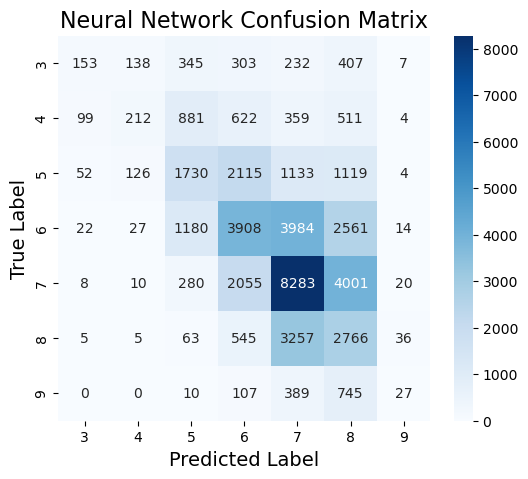

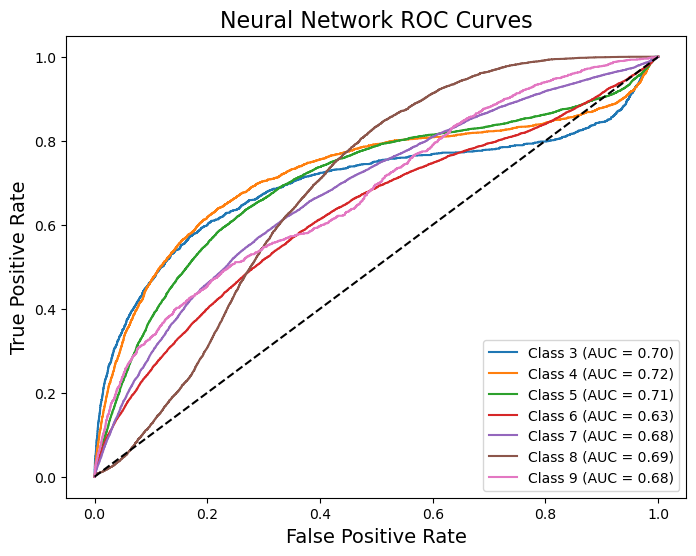

In [6]:
# =============================================================================
# PART 3: Neural Network for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Neural Network Fit and Predict ---
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), random_state=42, early_stopping=True)
# nn_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.1, learning_rate='adaptive', activation='tanh', early_stopping=True, momentum=0.9, random_state=42, max_iter=500)

nn_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_nn = nn_model.predict(X_test_scaled_preprocessed)

"""
# (Optional) Plot the loss curve to visualize the training process.
plt.figure(figsize=(8, 6))
plt.plot(nn_model.loss_curve_, label='Training Loss', linewidth=2)
plt.title('Neural Network Loss Curve', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
"""

# --- Step 2: classification report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_nn))

# --- Step 3: Confusion Matrix
cm_nn = confusion_matrix(y_test_preprocessed, y_pred_nn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Neural Network Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_nn = nn_model.classes_
y_test_nn_bin = label_binarize(y_test_preprocessed, classes=classes_nn)
y_score_nn = nn_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class.
fpr_nn, tpr_nn, roc_auc_nn = dict(), dict(), dict()
for i, cls in enumerate(classes_nn):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(y_test_nn_bin[:, i], y_score_nn[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

# Plot the ROC curves for all classes.
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_nn):
    plt.plot(fpr_nn[i], tpr_nn[i], label=f'Class {cls} (AUC = {roc_auc_nn[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Neural Network ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 4) Ensemble Methods

### 4.1) Random Forest

[random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- dopo c'è il plot dell'ultimo albero fra i 300 della foresta e dell'albero più "influente" con l'accuracy più alta

Classification Report:
               precision    recall  f1-score   support

           3       0.50      0.14      0.22      1585
           4       0.38      0.13      0.19      2688
           5       0.38      0.30      0.34      6279
           6       0.42      0.46      0.44     11696
           7       0.47      0.70      0.57     14657
           8       0.45      0.24      0.32      6677
           9       0.64      0.14      0.23      1278

    accuracy                           0.44     44860
   macro avg       0.46      0.30      0.33     44860
weighted avg       0.44      0.44      0.42     44860



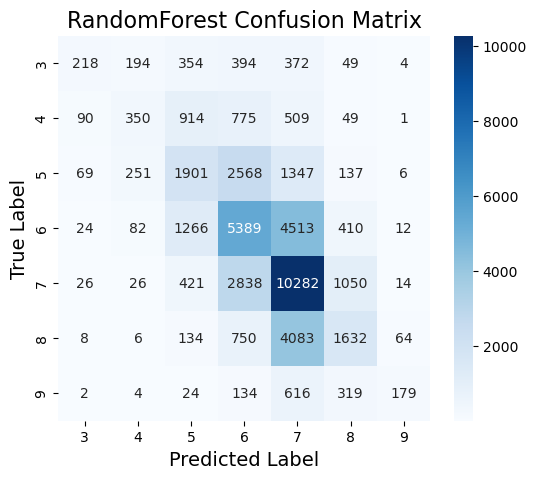

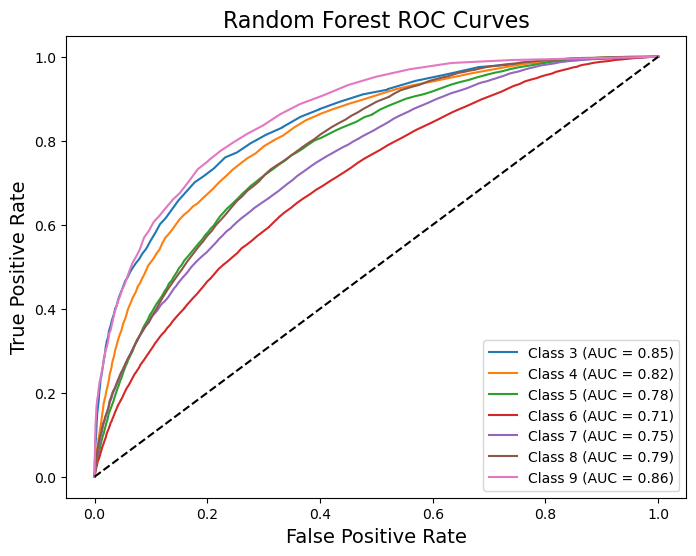

In [7]:
# =============================================================================
# PART 4: RandomForestClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training ---
rf_model = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_rf = rf_model.predict(X_test_scaled_preprocessed)

# --- Step 2: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_rf))

# --- Step 3: Confusion Matrix ---
cm_rf = confusion_matrix(y_test_preprocessed, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('RandomForest Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_rf = rf_model.classes_
y_test_rf_bin = label_binarize(y_test_preprocessed, classes=classes_rf)
y_score_rf = rf_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class.
fpr_rf, tpr_rf, roc_auc_rf = dict(), dict(), dict()
for i, cls in enumerate(classes_rf):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_rf_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot the ROC curves for all classes.
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_rf):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Class {cls} (AUC = {roc_auc_rf[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

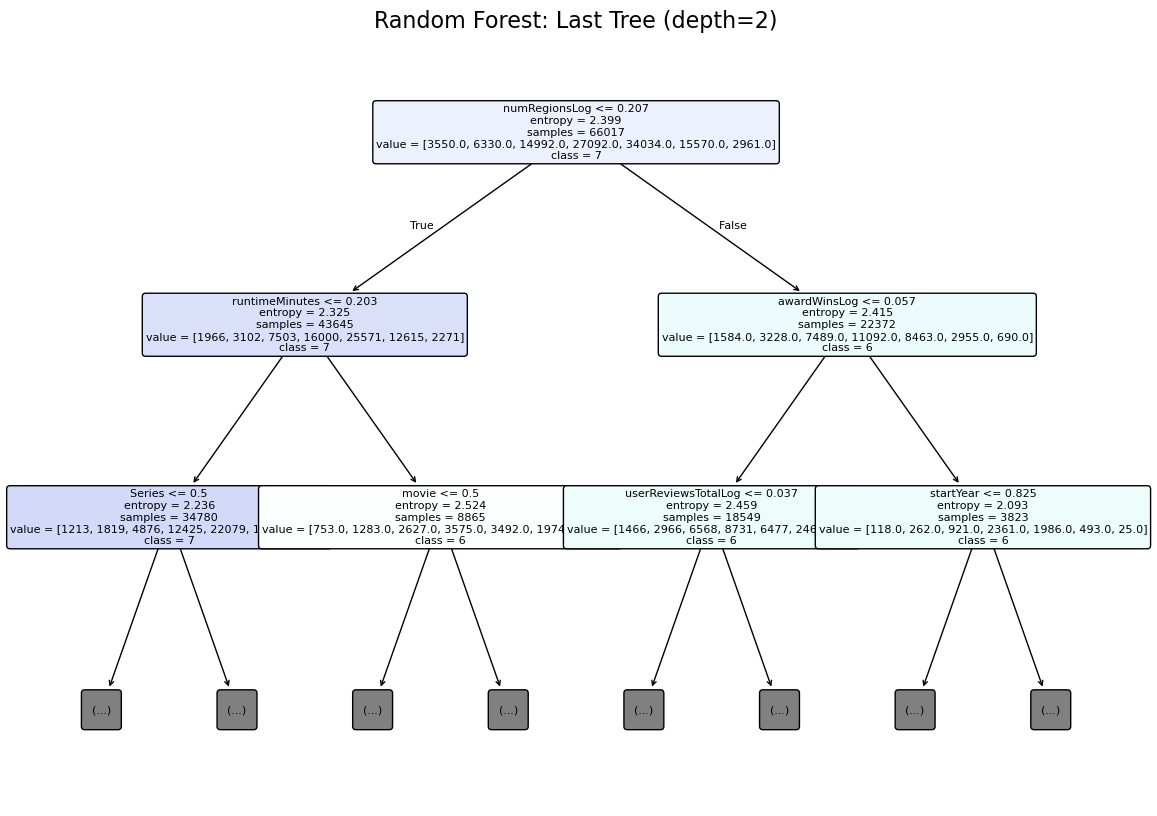

'\n# =============================================================================\n# Identify and plot the single best-performing tree in the forest\n# =============================================================================\n# Step A: Evaluate each tree’s accuracy on the test set\ntree_accuracies = [tree.score(X_test_scaled_preprocessed, y_test_preprocessed) for tree in rf_model.estimators_]\n\n# Step B: Find the index of the best tree\nbest_tree_idx = int(np.argmax(tree_accuracies))\nprint(f"Best tree index: {best_tree_idx}, accuracy: {tree_accuracies[best_tree_idx]:.4f}")\n\n# Step C: Plot that best tree (limit depth for readability)\nplt.figure(figsize=(14, 10))\nplot_tree(rf_model.estimators_[best_tree_idx], feature_names=attributes, class_names=[str(c) for c in rf_model.classes_], filled=True, rounded=True, fontsize=8, max_depth=3)\nplt.title(f"Random Forest: Tree #{best_tree_idx} (best accuracy)", fontsize=16)\nplt.show()\n'

In [8]:
# --- Step 5: Tree Visualization (shallow view of the first tree) ---
plt.figure(figsize=(14, 10))
plot_tree(rf_model.estimators_[299], feature_names=attributes, class_names=[str(c) for c in rf_model.classes_], filled=True, rounded=True, fontsize=8, max_depth=2)
plt.title("Random Forest: Last Tree (depth=2)", fontsize=16)
plt.show()

"""
# =============================================================================
# Identify and plot the single best-performing tree in the forest
# =============================================================================
# Step A: Evaluate each tree’s accuracy on the test set
tree_accuracies = [tree.score(X_test_scaled_preprocessed, y_test_preprocessed) for tree in rf_model.estimators_]

# Step B: Find the index of the best tree
best_tree_idx = int(np.argmax(tree_accuracies))
print(f"Best tree index: {best_tree_idx}, accuracy: {tree_accuracies[best_tree_idx]:.4f}")

# Step C: Plot that best tree (limit depth for readability)
plt.figure(figsize=(14, 10))
plot_tree(rf_model.estimators_[best_tree_idx], feature_names=attributes, class_names=[str(c) for c in rf_model.classes_], filled=True, rounded=True, fontsize=8, max_depth=3)
plt.title(f"Random Forest: Tree #{best_tree_idx} (best accuracy)", fontsize=16)
plt.show()
"""

### 4.2) Bagging

[bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

- RandomForest = Bagging (bootstraps rows) + Random Feature Subsampling without replacement at every split
- BaggingClassifier with DecisionTrees = Bagging Only (bootstraps rows) - by default uses all features at each split
  - make them equal: if added 'max_features' (how many columns each tree sees) in BaggingClassifier Hyperparameter as float (fraction of all features) would only subsample features once per tree not at every split, instead by setting 'max_features' on the base DecisionTree you get per‑split randomness just like RandomForest

Classification Report:
               precision    recall  f1-score   support

           3       0.53      0.14      0.22      1585
           4       0.39      0.14      0.20      2688
           5       0.38      0.31      0.34      6279
           6       0.42      0.46      0.44     11696
           7       0.48      0.70      0.57     14657
           8       0.44      0.25      0.32      6677
           9       0.63      0.13      0.21      1278

    accuracy                           0.45     44860
   macro avg       0.47      0.30      0.33     44860
weighted avg       0.44      0.45      0.42     44860



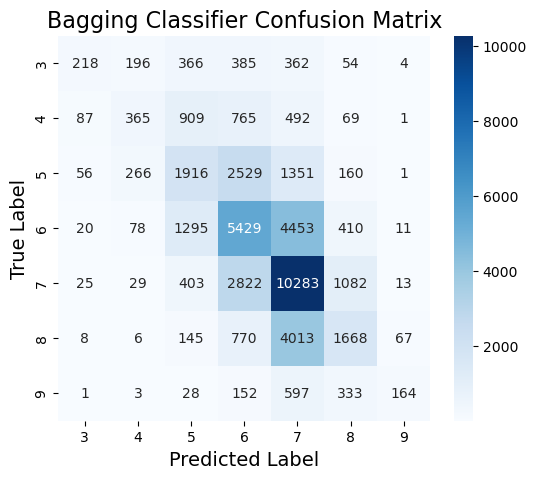

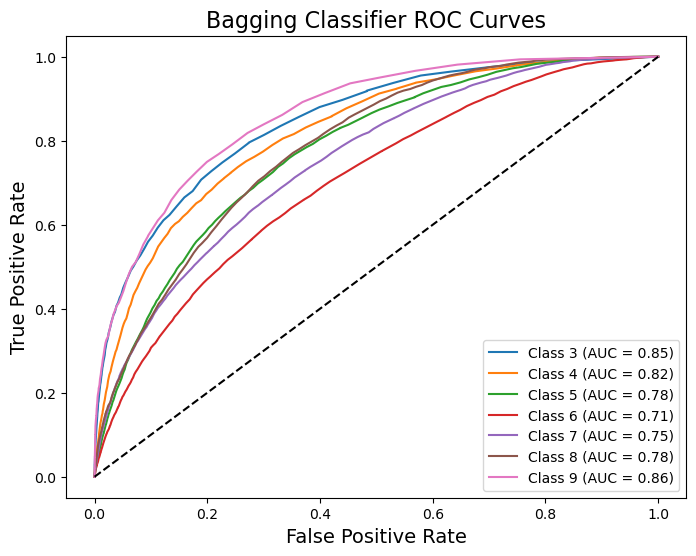

In [9]:
# =============================================================================
# PART 5: BaggingClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training - Trying to mimic the 'RandomForestClassifier' model ---
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(max_features=int(np.sqrt(X_train_scaled_preprocessed.shape[1])), random_state=42), n_estimators=300, random_state=42, n_jobs=-1)
bag_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_bag = bag_model.predict(X_test_scaled_preprocessed)

# --- Step 2: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_bag))

# --- Step 3: Confusion Matrix ---
cm_bag = confusion_matrix(y_test_preprocessed, y_pred_bag)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bag, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Bagging Classifier Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_bag = bag_model.classes_
y_test_bag_bin = label_binarize(y_test_preprocessed, classes=classes_bag)
y_score_bag = bag_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class
fpr_bag, tpr_bag, roc_auc_bag = {}, {}, {}
for i, cls in enumerate(classes_bag):
    fpr_bag[i], tpr_bag[i], _ = roc_curve(y_test_bag_bin[:, i], y_score_bag[:, i])
    roc_auc_bag[i] = auc(fpr_bag[i], tpr_bag[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_bag):
    plt.plot(fpr_bag[i], tpr_bag[i], label=f'Class {cls} (AUC = {roc_auc_bag[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Bagging Classifier ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 4.3) AdaBoost (Adaptive Boosting)

[adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Classification Report:
               precision    recall  f1-score   support

           3       0.56      0.15      0.23      1585
           4       0.42      0.14      0.21      2688
           5       0.38      0.31      0.34      6279
           6       0.42      0.48      0.45     11696
           7       0.48      0.70      0.57     14657
           8       0.48      0.24      0.32      6677
           9       0.63      0.15      0.24      1278

    accuracy                           0.45     44860
   macro avg       0.48      0.31      0.34     44860
weighted avg       0.45      0.45      0.43     44860



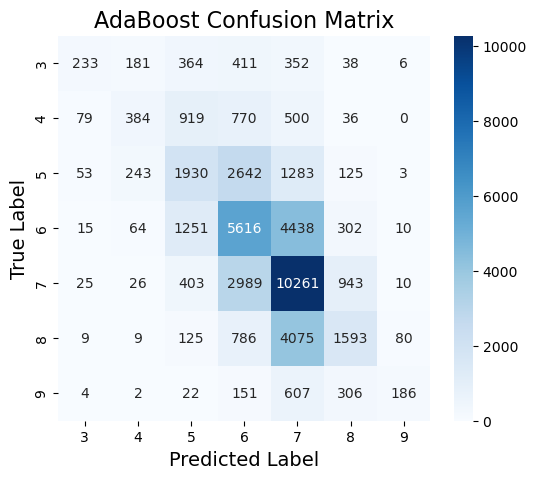

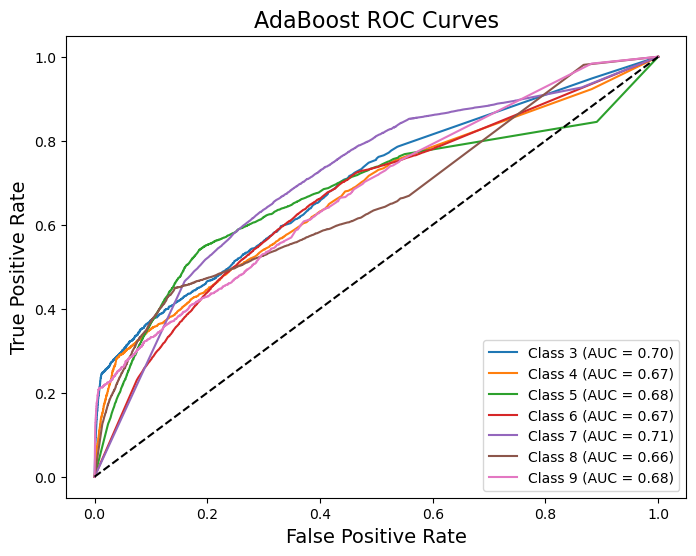

In [10]:
# =============================================================================
# PART 6: AdaBoostClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training ---
#ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, learning_rate=1.5, random_state=42)
#ada_model = AdaBoostClassifier(estimator=BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42, n_jobs=-1), n_estimators=10, random_state=42, n_jobs=-1), n_estimators=10, learning_rate=1.0, random_state=42)
ada_model = AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1), n_estimators=10, learning_rate=1.3, random_state=42)
ada_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_ada = ada_model.predict(X_test_scaled_preprocessed)

# --- Step 2: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_ada))

# --- Step 2: Confusion Matrix ---
cm_ada = confusion_matrix(y_test_preprocessed, y_pred_ada)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ada, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('AdaBoost Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_ada = ada_model.classes_
y_test_ada_bin = label_binarize(y_test_preprocessed, classes=classes_ada)
y_score_ada = ada_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class
fpr_ada, tpr_ada, roc_auc_ada = {}, {}, {}
for i, cls in enumerate(classes_ada):
    fpr_ada[i], tpr_ada[i], _ = roc_curve(y_test_ada_bin[:, i], y_score_ada[:, i])
    roc_auc_ada[i] = auc(fpr_ada[i], tpr_ada[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_ada):
    plt.plot(fpr_ada[i], tpr_ada[i], label=f'Class {cls} (AUC = {roc_auc_ada[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AdaBoost ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 5) Gradient Boosting

### 5.1) Gradient Boosting Machine

[gbm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Classification Report:
               precision    recall  f1-score   support

           3       0.41      0.06      0.11      1585
           4       0.45      0.06      0.11      2688
           5       0.35      0.23      0.28      6279
           6       0.38      0.35      0.36     11696
           7       0.42      0.79      0.55     14657
           8       0.36      0.06      0.11      6677
           9       0.13      0.06      0.08      1278

    accuracy                           0.40     44860
   macro avg       0.36      0.23      0.23     44860
weighted avg       0.38      0.40      0.34     44860



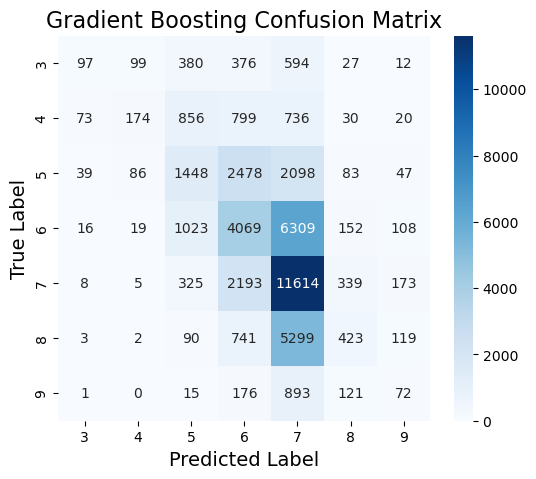

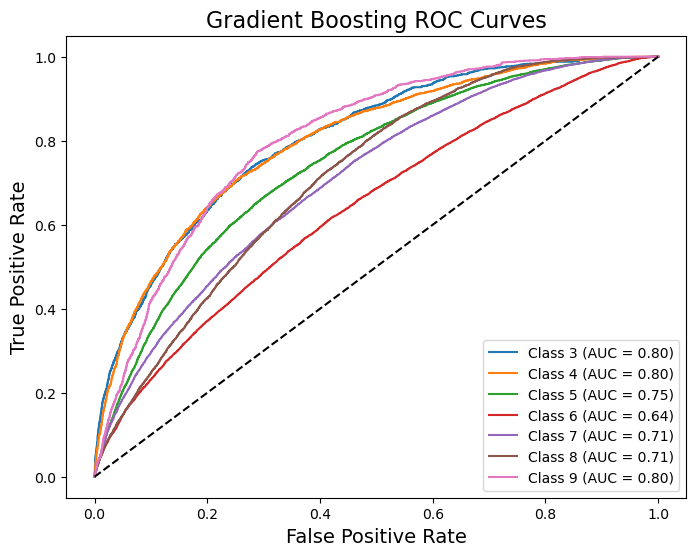

In [11]:
# =============================================================================
# PART 7: GradientBoostingClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training ---
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_gb = gb_model.predict(X_test_scaled_preprocessed)

# --- Step 2: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_gb))

# --- Step 3: Confusion Matrix ---
cm_gb = confusion_matrix(y_test_preprocessed, y_pred_gb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Gradient Boosting Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_gb = gb_model.classes_
y_test_gb_bin = label_binarize(y_test_preprocessed, classes=classes_gb)
y_score_gb = gb_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class
fpr_gb, tpr_gb, roc_auc_gb = {}, {}, {}
for i, cls in enumerate(classes_gb):
    fpr_gb[i], tpr_gb[i], _ = roc_curve(y_test_gb_bin[:, i], y_score_gb[:, i])
    roc_auc_gb[i] = auc(fpr_gb[i], tpr_gb[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_gb):
    plt.plot(fpr_gb[i], tpr_gb[i], label=f'Class {cls} (AUC = {roc_auc_gb[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Gradient Boosting ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 5.1) Histogram-based Gradient Boosting Machine

[histgbm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#)

- This estimator is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000)

Classification Report:
               precision    recall  f1-score   support

           3       0.39      0.13      0.20      1585
           4       0.40      0.13      0.20      2688
           5       0.37      0.27      0.31      6279
           6       0.40      0.37      0.38     11696
           7       0.44      0.73      0.55     14657
           8       0.36      0.19      0.25      6677
           9       0.44      0.11      0.17      1278

    accuracy                           0.42     44860
   macro avg       0.40      0.28      0.29     44860
weighted avg       0.40      0.42      0.38     44860



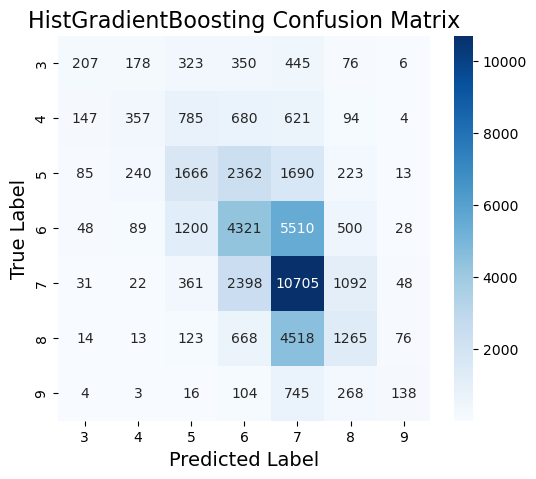

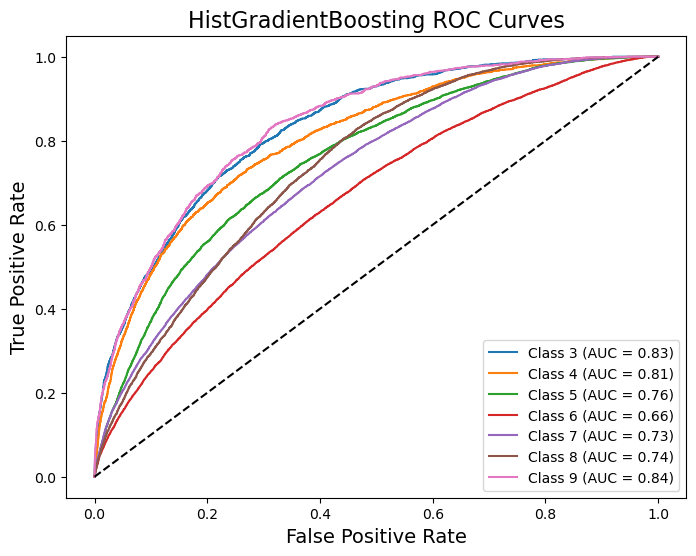

In [12]:
# =============================================================================
# PART 8: HistGradientBoostingClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training ---
hgb_model = HistGradientBoostingClassifier(max_iter=1000, learning_rate=0.1, max_depth=None, random_state=42)
hgb_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_hgb = hgb_model.predict(X_test_scaled_preprocessed)

# --- Step 2: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_hgb))

# --- Step 3: Confusion Matrix ---
cm_hgb = confusion_matrix(y_test_preprocessed, y_pred_hgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_hgb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('HistGradientBoosting Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_hgb = hgb_model.classes_
y_test_hgb_bin = label_binarize(y_test_preprocessed, classes=classes_hgb)

# Predict probability estimates
y_score_hgb = hgb_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class
fpr_hgb, tpr_hgb, roc_auc_hgb = {}, {}, {}
for i, cls in enumerate(classes_hgb):
    fpr_hgb[i], tpr_hgb[i], _ = roc_curve(y_test_hgb_bin[:, i], y_score_hgb[:, i])
    roc_auc_hgb[i] = auc(fpr_hgb[i], tpr_hgb[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_hgb):
    plt.plot(fpr_hgb[i], tpr_hgb[i], label=f'Class {cls} (AUC = {roc_auc_hgb[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("HistGradientBoosting ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 5.2) eXtreme Gradient Boosting

[xgboost](https://xgboost.readthedocs.io/en/stable/parameter.html)

Classification Report:
               precision    recall  f1-score   support

           3       0.40      0.15      0.22      1585
           4       0.35      0.17      0.23      2688
           5       0.37      0.28      0.32      6279
           6       0.40      0.38      0.39     11696
           7       0.45      0.68      0.54     14657
           8       0.33      0.24      0.28      6677
           9       0.40      0.09      0.15      1278

    accuracy                           0.41     44860
   macro avg       0.39      0.28      0.30     44860
weighted avg       0.40      0.41      0.39     44860



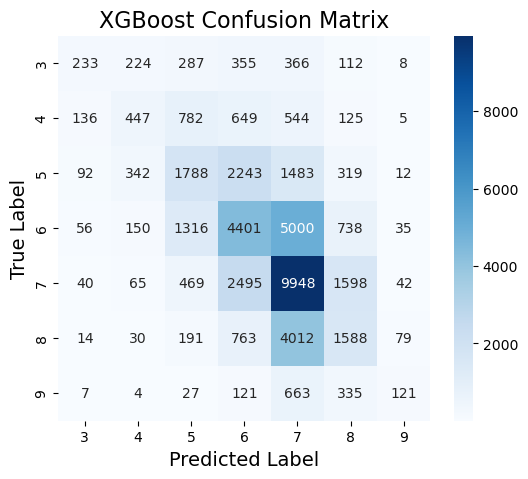

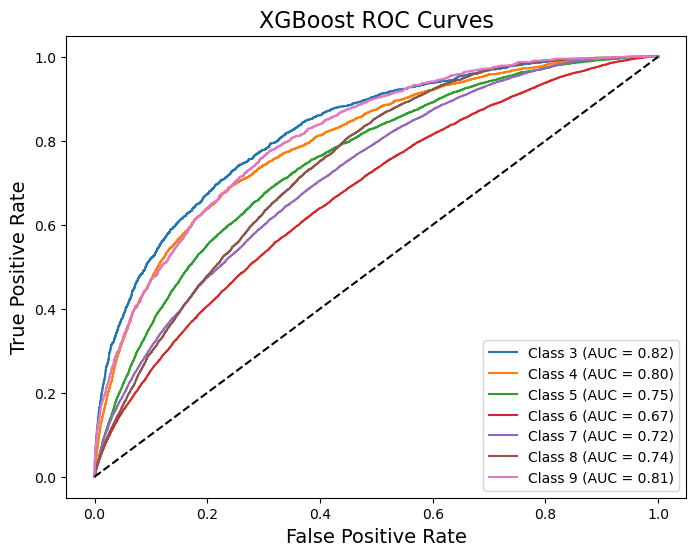

In [13]:
# =============================================================================
# PART 9: XGBClassifier for Grouped Rating Prediction
# =============================================================================

# --- Encode the original labels to 0…6 for XGBoost ---
le = LabelEncoder().fit(y_train_preprocessed)
y_train_enc = le.transform(y_train_preprocessed)
y_test_enc  = le.transform(y_test_preprocessed)

# --- Step 1: Model Initialization and Training ---
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.3, max_depth=None, gamma=0.0, reg_lambda=1, tree_method='auto', use_label_encoder=False, objective='multi:softmax', num_class=len(le.classes_), eval_metric='mlogloss', verbosity=0, random_state=42)
xgb_model.fit(X_train_scaled_preprocessed, y_train_enc)

# --- Step 2: Prediction (and inverse‐transform back to original labels) ---
y_pred_enc = xgb_model.predict(X_test_scaled_preprocessed)
y_pred_xgb = le.inverse_transform(y_pred_enc)

# --- Step 3: Classification Report & Confusion Matrix ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_xgb))

cm_xgb = confusion_matrix(y_test_preprocessed, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('XGBoost Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_enc = xgb_model.classes_                      # [0,1,...,6]
classes_orig = le.inverse_transform(classes_enc)      # [3,4,...,9]
y_test_enc_bin = label_binarize(y_test_enc, classes=classes_enc)
y_score_xgb  = xgb_model.predict_proba(X_test_scaled_preprocessed)

fpr_xgb, tpr_xgb, roc_auc_xgb = {}, {}, {}
plt.figure(figsize=(8, 6))
for i, cls_enc in enumerate(classes_enc):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_enc_bin[:, i], y_score_xgb[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])
    plt.plot(fpr_xgb[i], tpr_xgb[i], label=f'Class {classes_orig[i]} (AUC = {roc_auc_xgb[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("XGBoost ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 5.3) Light GBM

[lightgbm](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

Classification Report:
               precision    recall  f1-score   support

           3       0.41      0.12      0.19      1585
           4       0.37      0.13      0.20      2688
           5       0.37      0.28      0.32      6279
           6       0.40      0.35      0.37     11696
           7       0.44      0.75      0.56     14657
           8       0.36      0.18      0.24      6677
           9       0.37      0.12      0.18      1278

    accuracy                           0.42     44860
   macro avg       0.39      0.28      0.29     44860
weighted avg       0.40      0.42      0.38     44860



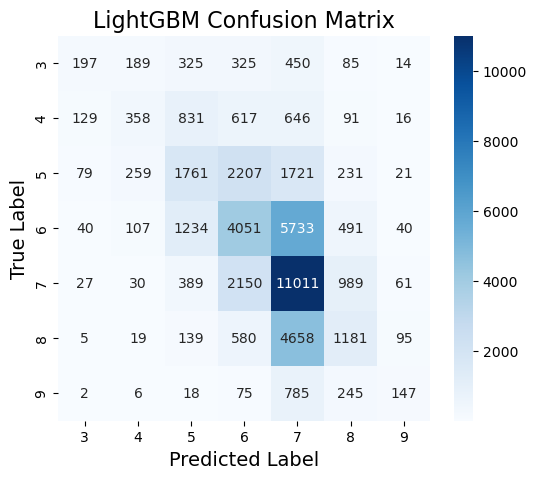

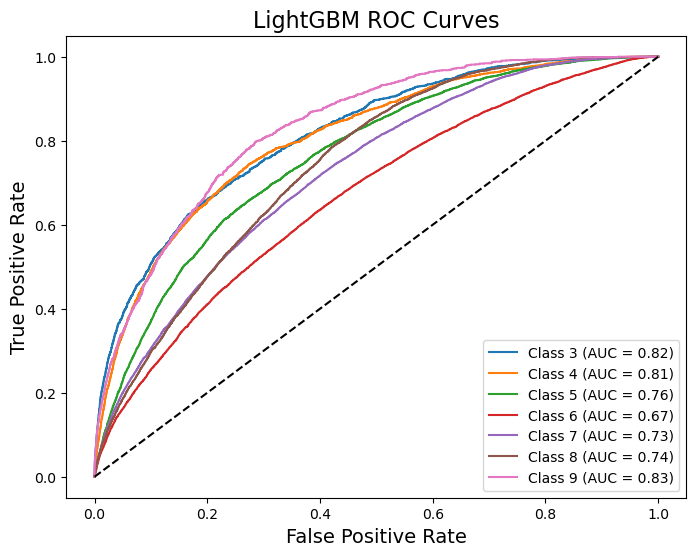

In [14]:
# =============================================================================
# PART 10: LGBMClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training ---
lgbm_model = LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=None, boosting='gbdt', metric="multi_logloss", objective="multiclass", reg_lambda=0.0, cat_smooth=10.0, is_unbalance=True, n_jobs=-1, verbose=-1, random_state=42)
lgbm_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_lgbm = lgbm_model.predict(X_test_scaled_preprocessed)

# --- Step 3: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_lgbm))

# --- Step 3: Confusion Matrix ---
cm_lgbm = confusion_matrix(y_test_preprocessed, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('LightGBM Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_lgbm = lgbm_model.classes_
y_test_lgbm_bin = label_binarize(y_test_preprocessed, classes=classes_lgbm)

# Predict probability estimates
y_score_lgbm = lgbm_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class
fpr_lgbm, tpr_lgbm, roc_auc_lgbm = {}, {}, {}
for i, cls in enumerate(classes_lgbm):
    fpr_lgbm[i], tpr_lgbm[i], _ = roc_curve(y_test_lgbm_bin[:, i], y_score_lgbm[:, i])
    roc_auc_lgbm[i] = auc(fpr_lgbm[i], tpr_lgbm[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_lgbm):
    plt.plot(fpr_lgbm[i], tpr_lgbm[i], label=f'Class {cls} (AUC = {roc_auc_lgbm[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("LightGBM ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### 5.4) CatBoost

[catboost](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier)

Classification Report:
               precision    recall  f1-score   support

           3       0.48      0.11      0.17      1585
           4       0.42      0.10      0.17      2688
           5       0.38      0.27      0.32      6279
           6       0.40      0.37      0.39     11696
           7       0.44      0.73      0.55     14657
           8       0.33      0.19      0.24      6677
           9       0.54      0.06      0.11      1278

    accuracy                           0.41     44860
   macro avg       0.43      0.26      0.28     44860
weighted avg       0.41      0.41      0.38     44860



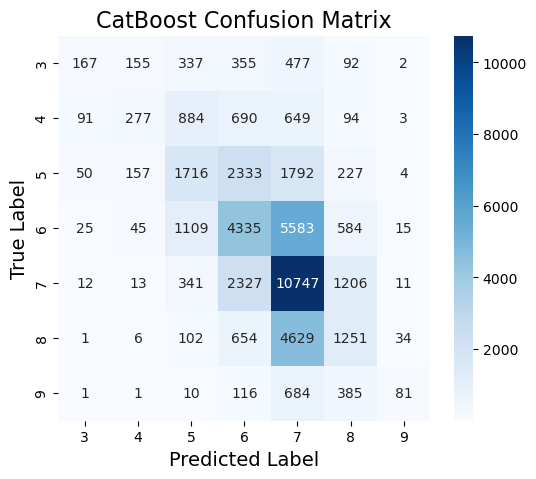

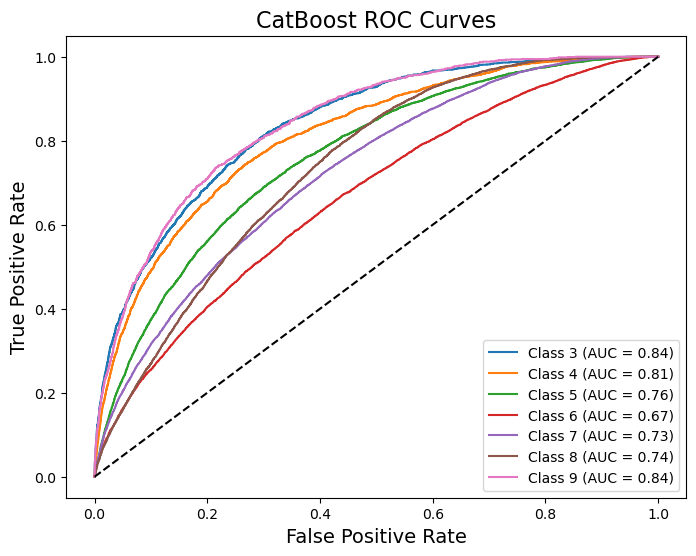

In [22]:
# =============================================================================
# PART 11: CatBoostClassifier for Grouped Rating Prediction
# =============================================================================

# --- Step 1: Model Initialization and Training ---
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=None, random_seed=42, verbose=0)
cat_model.fit(X_train_scaled_preprocessed, y_train_preprocessed)
y_pred_cat = cat_model.predict(X_test_scaled_preprocessed)

# --- Step 2: Classification Report ---
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_cat))

# --- Step 3: Confusion Matrix ---
cm_cat = confusion_matrix(y_test_preprocessed, y_pred_cat)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_preprocessed), yticklabels=np.unique(y_train_preprocessed))
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('CatBoost Confusion Matrix', fontsize=16)
plt.show()

# --- Step 4: ROC Curve Evaluation for Multiclass Classification ---
classes_cat = cat_model.classes_
y_test_cat_bin = label_binarize(y_test_preprocessed, classes=classes_cat)

# Predict probability estimates
y_score_cat = cat_model.predict_proba(X_test_scaled_preprocessed)

# Compute ROC curve and AUC for each class
fpr_cat, tpr_cat, roc_auc_cat = {}, {}, {}
for i, cls in enumerate(classes_cat):
    fpr_cat[i], tpr_cat[i], _ = roc_curve(y_test_cat_bin[:, i], y_score_cat[:, i])
    roc_auc_cat[i] = auc(fpr_cat[i], tpr_cat[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_cat):
    plt.plot(fpr_cat[i], tpr_cat[i], label=f'Class {cls} (AUC = {roc_auc_cat[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("CatBoost ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### Final Evaluation

- logistic regression - 35 accuracy , 32 weighted avg
- linear svm - 35 accuracy , 32 weighted avg
- **neural network** - 38 accuracy , 37 weighted avg
- **random forest** - 44 accuracy , 42 weighted avg
- **bagging** - 45 accuracy , 42 weighted avg
- **adaboost** - 45 accuracy , 43 weighted avg
- gbm - 40 accuracy , 34 weighted avg
- hist gbm - 42 accuracy , 38 weighted avg
- xgb - 41 accuracy , 39 weighted avg
- lgbm - 42 accuracy , 38 weighted avg
- cat - 41 accuracy , 38 weighted avg

In [24]:
# =============================================================================
# Recap “Worst” 3→9 and 9→3 Errors for All 11 Classifiers
# =============================================================================

# 1. Dictionary mapping each model name to its precomputed predictions
y_preds = {
    "LogisticRegression":    y_pred_lr,
    "SVC":                   y_pred_linear_svc,
    "NeuralNetwork":         y_pred_nn,
    "RandomForest":          y_pred_rf,
    "BaggingClassifier":     y_pred_bag,
    "AdaBoostClassifier":    y_pred_ada,
    "GradientBoosting":      y_pred_gb,
    "HistGradientBoosting":  y_pred_hgb,
    "XGBClassifier":         y_pred_xgb,
    "LGBMClassifier":        y_pred_lgbm
}

# 2. Loop over each model’s predictions and report the “corner” errors
for name, y_pred in y_preds.items():
    idx_3_to_9 = np.where((y_test_preprocessed == 3) & (y_pred == 9))[0]
    idx_9_to_3 = np.where((y_test_preprocessed == 9) & (y_pred == 3))[0]
    
    print(f"\n=== {name} ===")
    print(f" true=3 → pred=9  ({len(idx_3_to_9)} samples):")
    for idx in idx_3_to_9:
        print(f"   idx={idx:5d} | true=3 → pred=9")
    
    print(f" true=9 → pred=3  ({len(idx_9_to_3)} samples):")
    for idx in idx_9_to_3:
        print(f"   idx={idx:5d} | true=9 → pred=3")


=== LogisticRegression ===
 true=3 → pred=9  (0 samples):
 true=9 → pred=3  (0 samples):

=== SVC ===
 true=3 → pred=9  (1 samples):
   idx=30056 | true=3 → pred=9
 true=9 → pred=3  (0 samples):

=== NeuralNetwork ===
 true=3 → pred=9  (7 samples):
   idx=  275 | true=3 → pred=9
   idx= 1376 | true=3 → pred=9
   idx= 2229 | true=3 → pred=9
   idx=10144 | true=3 → pred=9
   idx=13168 | true=3 → pred=9
   idx=18588 | true=3 → pred=9
   idx=26390 | true=3 → pred=9
 true=9 → pred=3  (0 samples):

=== RandomForest ===
 true=3 → pred=9  (4 samples):
   idx=12600 | true=3 → pred=9
   idx=16293 | true=3 → pred=9
   idx=18528 | true=3 → pred=9
   idx=24362 | true=3 → pred=9
 true=9 → pred=3  (2 samples):
   idx= 1566 | true=9 → pred=3
   idx= 2420 | true=9 → pred=3

=== BaggingClassifier ===
 true=3 → pred=9  (4 samples):
   idx=16293 | true=3 → pred=9
   idx=18528 | true=3 → pred=9
   idx=24362 | true=3 → pred=9
   idx=38615 | true=3 → pred=9
 true=9 → pred=3  (1 samples):
   idx=  376 | true

In [ ]:
# =============================================================================
# Find records misclassified by more than one model in the “3→9” or “9→3” corners
# =============================================================================

from collections import defaultdict

# 1. Build a mapping: test‐index → list of (model_name, error_type)
mis_map = defaultdict(list)

for name, y_pred in y_preds.items():
    # 3→9 errors
    for idx in np.where((y_test_preprocessed == 3) & (y_pred == 9))[0]:
        mis_map[idx].append((name, "3→9"))
    # 9→3 errors
    for idx in np.where((y_test_preprocessed == 9) & (y_pred == 3))[0]:
        mis_map[idx].append((name, "9→3"))

# 2. Filter to only those indices misclassified by more than one model
shared_errors = {idx: errs for idx, errs in mis_map.items() if len(errs) > 1}

# 3. Print the overlaps
print("Indices misclassified by multiple models in the extreme corners:\n")
for idx, errs in sorted(shared_errors.items()):
    models_and_types = ", ".join(f"{m}({t})" for m, t in errs)
    print(f"  idx={idx:5d}  →  {models_and_types}")

Indices misclassified by multiple models in the extreme corners:

  idx=  927  →  AdaBoostClassifier(3→9), GradientBoosting(3→9)
  idx= 1566  →  RandomForest(9→3), AdaBoostClassifier(9→3)
  idx= 2420  →  RandomForest(9→3), AdaBoostClassifier(9→3)
  idx= 3199  →  AdaBoostClassifier(3→9), LGBMClassifier(3→9)
  idx= 3753  →  AdaBoostClassifier(3→9), HistGradientBoosting(3→9)
  idx= 3921  →  GradientBoosting(3→9), LGBMClassifier(3→9)
  idx= 4395  →  GradientBoosting(3→9), LGBMClassifier(3→9)
  idx= 9802  →  XGBClassifier(3→9), LGBMClassifier(3→9)
  idx=12600  →  RandomForest(3→9), XGBClassifier(3→9), LGBMClassifier(3→9)
  idx=13032  →  GradientBoosting(3→9), HistGradientBoosting(3→9), LGBMClassifier(3→9)
  idx=16293  →  RandomForest(3→9), BaggingClassifier(3→9), AdaBoostClassifier(3→9)
  idx=18528  →  RandomForest(3→9), BaggingClassifier(3→9), AdaBoostClassifier(3→9)
  idx=18552  →  XGBClassifier(9→3), LGBMClassifier(9→3)
  idx=24362  →  RandomForest(3→9), BaggingClassifier(3→9), AdaBoostC